In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
#import geopandas as gpd
import matplotlib as mpl
import matplotlib.patheffects as patheffects
#for statistical tests
import statsmodels.api as sm
from scipy import stats
import pingouin as pg


# The file has .xlsx extension, so use read_excel instead of read_csv to avoid UnicodeDecodeError
df_wbdi = pd.read_csv(r'C:\Users\kushn\Downloads\world_bank_development_indicators.csv')

df_income = pd.ExcelFile(r'C:\Users\kushn\Downloads\income.xlsx')

# Display sheet names in the Excel file
print("Sheet names in the Excel file:", df_income.sheet_names)

df_income_economies = pd.read_excel(df_income, sheet_name='List of economies')
#df_income_composition = pd.read_excel(df_income, sheet_name='composition')
#df_income_notes = pd.read_excel(df_income, sheet_name='notes')


Sheet names in the Excel file: ['List of economies', 'composition', 'notes']


In [2]:
df_wbdi.shape

(17272, 50)

In [3]:
def format_example_values(series):
    vals = series.dropna().unique()[:5]
    
    formatted = []
    for v in vals:
        if isinstance(v, (int, float, np.number)):
            formatted.append(f"{v:.2f}")
        else:
            formatted.append(str(v))
    return ", ".join(formatted)

summary_df = pd.DataFrame({
    "Feature/variable": df_wbdi.columns,
    "Data type": df_wbdi.dtypes.values.astype(str),
    "Description": [""] * len(df_wbdi.columns),
    "Number of Unique values": [df_wbdi[col].nunique() for col in df_wbdi.columns],
    "Example values": [format_example_values(df_wbdi[col]) for col in df_wbdi.columns]
})

# Show all rows without truncation
with pd.option_context("display.max_rows", None, "display.max_colwidth", None):
    print(summary_df.to_markdown(index=False))



| Feature/variable                          | Data type   | Description   |   Number of Unique values | Example values                                                                         |
|:------------------------------------------|:------------|:--------------|--------------------------:|:---------------------------------------------------------------------------------------|
| country                                   | object      |               |                       274 | Afghanistan, Africa Eastern and Southern, Africa Western and Central, Albania, Algeria |
| date                                      | object      |               |                        64 | 01-01-1960, 01-01-1961, 01-01-1962, 01-01-1963, 01-01-1964                             |
| agricultural_land%                        | float64     |               |                     10880 | 57.88, 57.96, 58.03, 58.12, 58.12                                                      |
| forest_land%                     

In [4]:
# Select only numeric columns
num_df = df_wbdi.select_dtypes(include="number")

# Compute descriptive statistics
summary_table = num_df.describe().loc[
    ["count", "mean", "std", "min", "25%", "50%", "75%", "max"]
]

# Optional: round to 2 decimals
summary_table = summary_table.round(2)

summary_table = summary_table.T

print(summary_table.to_markdown())


|                                           |   count |           mean |            std |            min |              25% |              50% |              75% |             max |
|:------------------------------------------|--------:|---------------:|---------------:|---------------:|-----------------:|-----------------:|-----------------:|----------------:|
| agricultural_land%                        |   14714 |   36.95        |   20.55        |    0.26        |     20.45        |     37.47        |     50.74        |    93.44        |
| forest_land%                              |    8176 |   32.41        |   23.36        |    0           |     12.43        |     30.77        |     47.12        |    98.57        |
| land_area                                 |   14930 |    5.07866e+06 |    1.40617e+07 |    2.03        |  21640           | 241930           |      1.44429e+06 |     1.29951e+08 |
| avg_precipitation                         |   10086 | 1214.02        |  810.57        | 

In [5]:
# Select categorical/object columns
cat_df = df_wbdi.select_dtypes(include=["object", "category"])

summary = pd.DataFrame(index=cat_df.columns)

# Count of non-missing values
summary["Count"] = cat_df.count()

# Number of unique values
summary["Number of unique values"] = cat_df.nunique()

# Most frequent value
summary["Most frequent value"] = cat_df.mode().iloc[0]

# Frequency of most frequent value
summary["Most frequent value (frequency)"] = [
    cat_df[col].value_counts().iloc[0] if cat_df[col].nunique() > 0 else 0
    for col in cat_df.columns
]

# Least frequent value
summary["Least frequent value"] = [
    cat_df[col].value_counts().idxmin() if cat_df[col].nunique() > 0 else None
    for col in cat_df.columns
]

# Frequency of least frequent value
summary["Least frequent value (frequency)"] = [
    cat_df[col].value_counts().iloc[-1] if cat_df[col].nunique() > 0 else 0
    for col in cat_df.columns
]

# Flip rows and columns
summary = summary.T

print(summary.to_markdown())


|                                  | country        | date       |
|:---------------------------------|:---------------|:-----------|
| Count                            | 17272          | 17272      |
| Number of unique values          | 274            | 64         |
| Most frequent value              | Afghanistan    | 01-01-1990 |
| Most frequent value (frequency)  | 64             | 274        |
| Least frequent value             | Czech Republic | 01-01-2021 |
| Least frequent value (frequency) | 31             | 266        |


In [6]:
# Add income/region information by merging the tables into a single dataframe.
df_wbdi = df_wbdi.merge(df_income_economies[['Economy', 'Income group', 'Region']], 
                       how='left', 
                       left_on='country', 
                       right_on='Economy').drop(columns=['Economy'])

In [7]:
# Cleaning: Clean up countries (some have weird names, e.g. post-demographic dividend)
df_wbdi['country'].unique()


# Drop rows that have a missing income group
df_wbdi = df_wbdi[~df_wbdi['Income group'].isna()]



In [8]:
# Impute or drop missing values
# Drop missing values where life expectancy is missing (as this is the variable I want to analyze)
print(df_wbdi['life_expectancy_at_birth'].isnull().sum())
df_wbdi = df_wbdi[~df_wbdi['life_expectancy_at_birth'].isna()]


1006


In [9]:
# Duplicates
print(df_wbdi.duplicated().sum())

# do not need to be dropped as there are none

0


In [10]:
# display the first, the last and a random sample of 7 entries
df_wbdi.head(1)
df_wbdi.tail(1)
df_wbdi.sample(7)

,country,date,agricultural_land%,forest_land%,land_area,avg_precipitation,trade_in_services%,control_of_corruption_estimate,control_of_corruption_std,access_to_electricity%,...,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,voice_and_accountability_std,intentional_homicides,Income group,Region
15562,Timor-Leste,01-01-1976,17.350370,NaN,14870.0,1500.0,NaN,NaN,NaN,NaN,...,38.268,37.854,25.957000,609650.0,518471.0,NaN,NaN,NaN,Lower middle income,East Asia & Pacific
7717,Jamaica,01-01-1968,47.737765,NaN,10830.0,2051.0,NaN,NaN,NaN,NaN,...,36.563,8.622,66.265000,1812209.0,1090678.0,NaN,NaN,NaN,Upper middle income,Latin America & Caribbean
10859,Morocco,01-01-1976,60.833520,NaN,446300.0,346.0,16.963356,NaN,NaN,NaN,...,41.566,13.990,51.936000,17756516.0,10937126.0,NaN,NaN,NaN,Lower middle income,"Middle East, North Africa, Afghanistan & Pakistan"
6117,Guam,01-01-1968,31.481481,NaN,540.0,NaN,NaN,NaN,NaN,NaN,...,30.949,5.594,64.152000,85046.0,35092.0,NaN,NaN,NaN,High income,East Asia & Pacific
3626,Cyprus,01-01-2002,15.151515,18.599134,9240.0,498.0,53.781596,1.126284,0.212333,100.000000,...,11.786,7.113,77.487000,982194.0,307486.0,1.117119,0.199188,0.203626,High income,Europe & Central Asia
5594,Gabon,01-01-2021,8.356565,91.274576,257670.0,NaN,NaN,-0.869527,0.199306,91.806404,...,27.142,7.258,65.821000,2341179.0,224215.0,-0.893327,0.126101,NaN,Upper middle income,Sub-Saharan Africa
5769,Germany,01-01-2004,48.779998,32.617484,348770.0,700.0,12.340163,1.840065,0.172068,100.000000,...,8.600,9.900,78.680488,82516260.0,19986263.0,1.496040,0.175458,1.368335,High income,Europe & Central Asia


In [11]:
# Get data type of relevant columns (live expectancy and income)
# @group add data types of relevant columns in your analysis here
df_wbdi[['life_expectancy_at_birth', 'Region']].dtypes


life_expectancy_at_birth    float64
Region                       object
dtype: object

In [12]:
# basic summary statistics for both categorical and numerical variables
df_wbdi.describe()
df_wbdi.dtypes

country                                       object
date                                          object
agricultural_land%                           float64
forest_land%                                 float64
land_area                                    float64
avg_precipitation                            float64
trade_in_services%                           float64
control_of_corruption_estimate               float64
control_of_corruption_std                    float64
access_to_electricity%                       float64
renewvable_energy_consumption%               float64
electric_power_consumption                   float64
CO2_emisions                                 float64
other_greenhouse_emisions                    float64
population_density                           float64
inflation_annual%                            float64
real_interest_rate                           float64
risk_premium_on_lending                      float64
research_and_development_expenditure%        f

In [13]:
df_wbdi.shape[0]

12337

In [14]:
df_wbdi.columns

Index(['country', 'date', 'agricultural_land%', 'forest_land%', 'land_area',
       'avg_precipitation', 'trade_in_services%',
       'control_of_corruption_estimate', 'control_of_corruption_std',
       'access_to_electricity%', 'renewvable_energy_consumption%',
       'electric_power_consumption', 'CO2_emisions',
       'other_greenhouse_emisions', 'population_density', 'inflation_annual%',
       'real_interest_rate', 'risk_premium_on_lending',
       'research_and_development_expenditure%', 'central_goverment_debt%',
       'tax_revenue%', 'expense%', 'goverment_effectiveness_estimate',
       'goverment_effectiveness_std', 'human_capital_index', 'doing_business',
       'time_to_get_operation_license', 'statistical_performance_indicators',
       'individuals_using_internet%', 'logistic_performance_index',
       'military_expenditure%', 'GDP_current_US',
       'political_stability_estimate', 'political_stability_std',
       'rule_of_law_estimate', 'rule_of_law_std',
       'reg

In [15]:
dataset = df_wbdi.copy()

In [16]:
# Format data
dataset["date"] = pd.to_datetime(dataset["date"])
dataset["year"] = dataset["date"].dt.year


In [17]:

corr = dataset.corr(numeric_only=True)

# Unstack matrix → (feature1, feature2) pairs
corr_pairs = corr.unstack()

# Remove self-correlations
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# Sort by absolute correlation
top10 = corr_pairs.abs().sort_values(ascending=False).head(30)

print(top10)


other_greenhouse_emisions           CO2_emisions                          0.996021
CO2_emisions                        other_greenhouse_emisions             0.996021
statistical_performance_indicators  electric_power_consumption            0.983109
electric_power_consumption          statistical_performance_indicators    0.983109
population                          rural_population                      0.968169
rural_population                    population                            0.968169
rule_of_law_estimate                control_of_corruption_estimate        0.938691
control_of_corruption_estimate      rule_of_law_estimate                  0.938691
rule_of_law_estimate                goverment_effectiveness_estimate      0.932252
goverment_effectiveness_estimate    rule_of_law_estimate                  0.932252
regulatory_quality_estimate         goverment_effectiveness_estimate      0.929666
goverment_effectiveness_estimate    regulatory_quality_estimate           0.929666
    

### Research Question 1: Correlation of population and Inflation by Region and Decade

### Research Question 2: Does life expectancy at birth relate to human capital index?

In [38]:
dataset = dataset.dropna(
    subset=["Region", "life_expectancy_at_birth", "human_capital_index"]
).reset_index(drop=True)


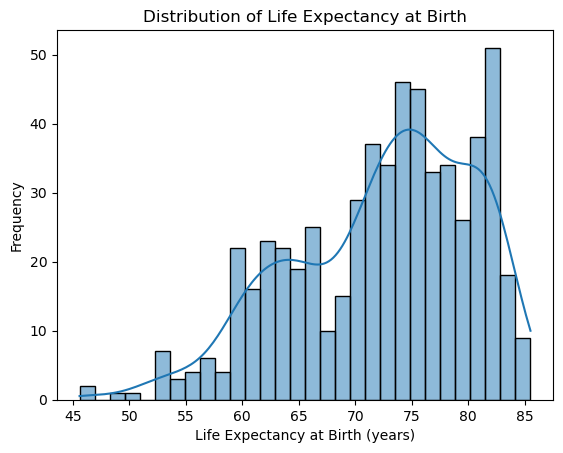

In [39]:
# check hci and life expectancy correlation
# then check one that does not really relate and try to explain why not
# Distribution of life expectancy at birth
dataset['life_expectancy_at_birth'] = pd.to_numeric(dataset['life_expectancy_at_birth'], errors='coerce')
dataset['log_life_expectancy_at_birth'] = np.log(dataset['life_expectancy_at_birth'].clip(lower=0) + 1)
dataset['sqrt_life_expectancy_at_birth'] = np.sqrt(dataset['life_expectancy_at_birth'])

# Min max scaling
min_life_exp = dataset['life_expectancy_at_birth'].min()
max_life_exp = dataset['life_expectancy_at_birth'].max()
dataset['scaled_life_expectancy_at_birth'] = (dataset['life_expectancy_at_birth'] - min_life_exp) / (max_life_exp - min_life_exp)

# Standard scaling
mean_life_exp = dataset['life_expectancy_at_birth'].mean()
std_life_exp = dataset['life_expectancy_at_birth'].std()
dataset['standardized_life_expectancy_at_birth'] = (dataset['life_expectancy_at_birth'] - mean_life_exp) / std_life_exp

sns.histplot(data=dataset, x='life_expectancy_at_birth', bins=30, kde=True)
plt.title('Distribution of Life Expectancy at Birth')
plt.xlabel('Life Expectancy at Birth (years)')
plt.ylabel('Frequency')
plt.show()

# Data is not normally distributed, even after trying various transformations

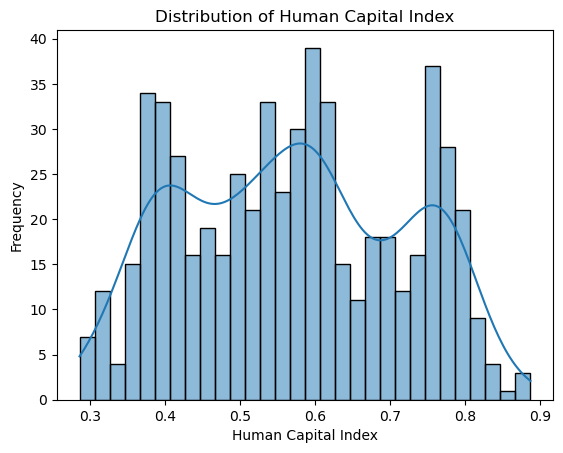

In [40]:
#Lof transformation to reduce skewness
dataset['human_capital_index'] = pd.to_numeric(dataset['human_capital_index'], errors='coerce')
dataset['log_human_capital_index'] = np.log(dataset['human_capital_index'].clip(lower=0) + 1)
dataset['sqrt_human_capital_index'] = np.sqrt(dataset['human_capital_index'])

# Min max scaling
min_hci = dataset['human_capital_index'].min()
max_hci = dataset['human_capital_index'].max()
dataset['scaled_human_capital_index'] = (dataset['human_capital_index'] - min_hci) / (max_hci - min_hci)

# Standard scaling
mean_hci = dataset['human_capital_index'].mean()
std_hci = dataset['human_capital_index'].std()
dataset['standardized_human_capital_index'] = (dataset['human_capital_index'] - mean_hci) / std_hci

sns.histplot(data=dataset, x='human_capital_index', bins=30, kde=True)
plt.title('Distribution of Human Capital Index')
plt.xlabel('Human Capital Index')
plt.ylabel('Frequency')
plt.show()

# Data is not normally distributed, even after trying various transformations


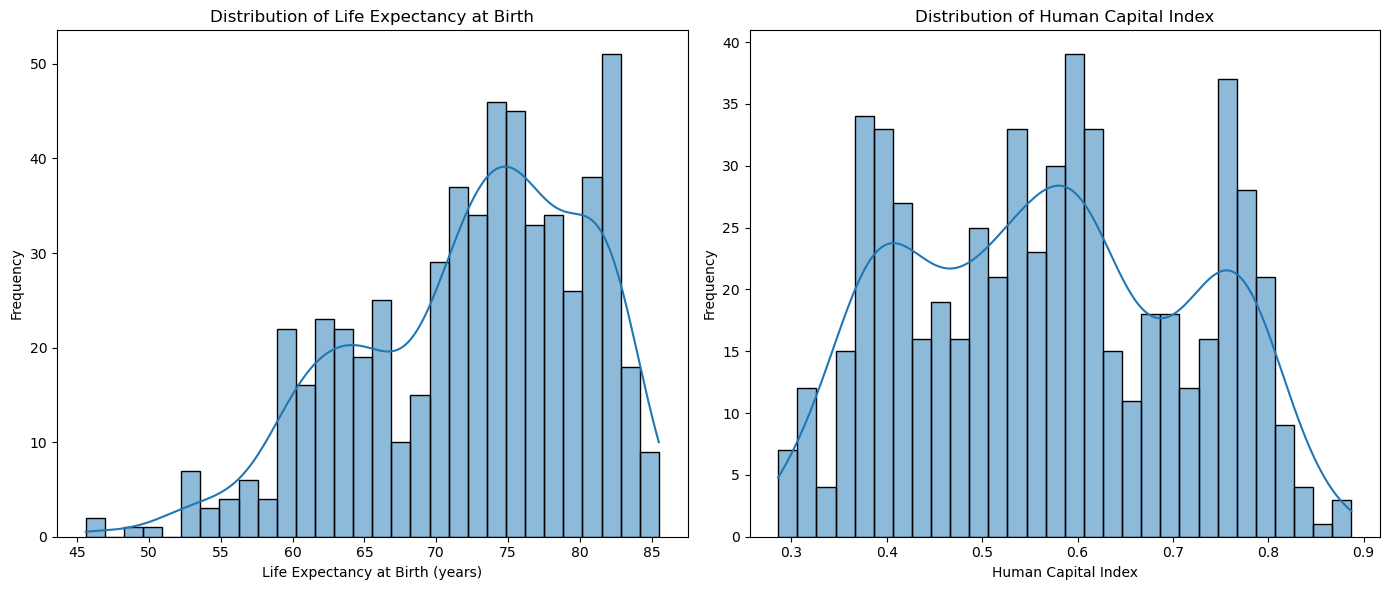

In [41]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figsize as needed

# Plot the first histogram
sns.histplot(data=dataset, x='life_expectancy_at_birth', bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Life Expectancy at Birth')
axes[0].set_xlabel('Life Expectancy at Birth (years)')
axes[0].set_ylabel('Frequency')

# Plot the second histogram
sns.histplot(data=dataset, x='human_capital_index', bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Human Capital Index')
axes[1].set_xlabel('Human Capital Index')
axes[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


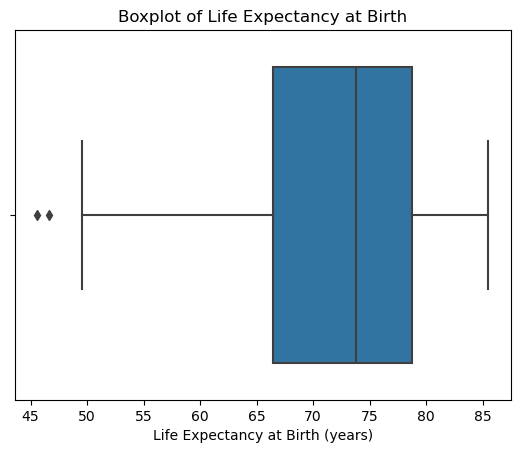

In [42]:
# Check for outliers
sns.boxplot(x=dataset['life_expectancy_at_birth'])
plt.title('Boxplot of Life Expectancy at Birth')
plt.xlabel('Life Expectancy at Birth (years)')
plt.show()

# there are outliers but they seem valid (countries with very low life expectancy due to various factors)

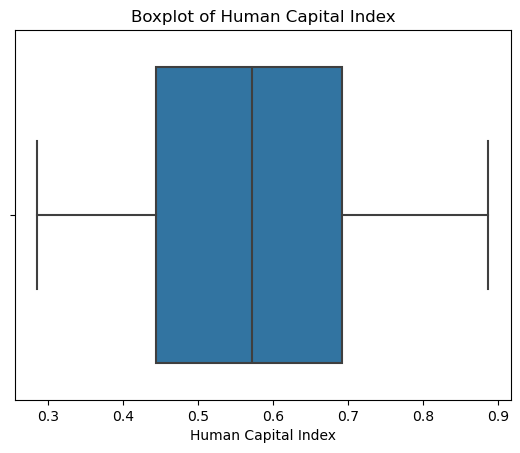

In [43]:
# Check for outliers
sns.boxplot(x=dataset['human_capital_index'])
plt.title('Boxplot of Human Capital Index')
plt.xlabel('Human Capital Index')
plt.show()

# no outliers detected

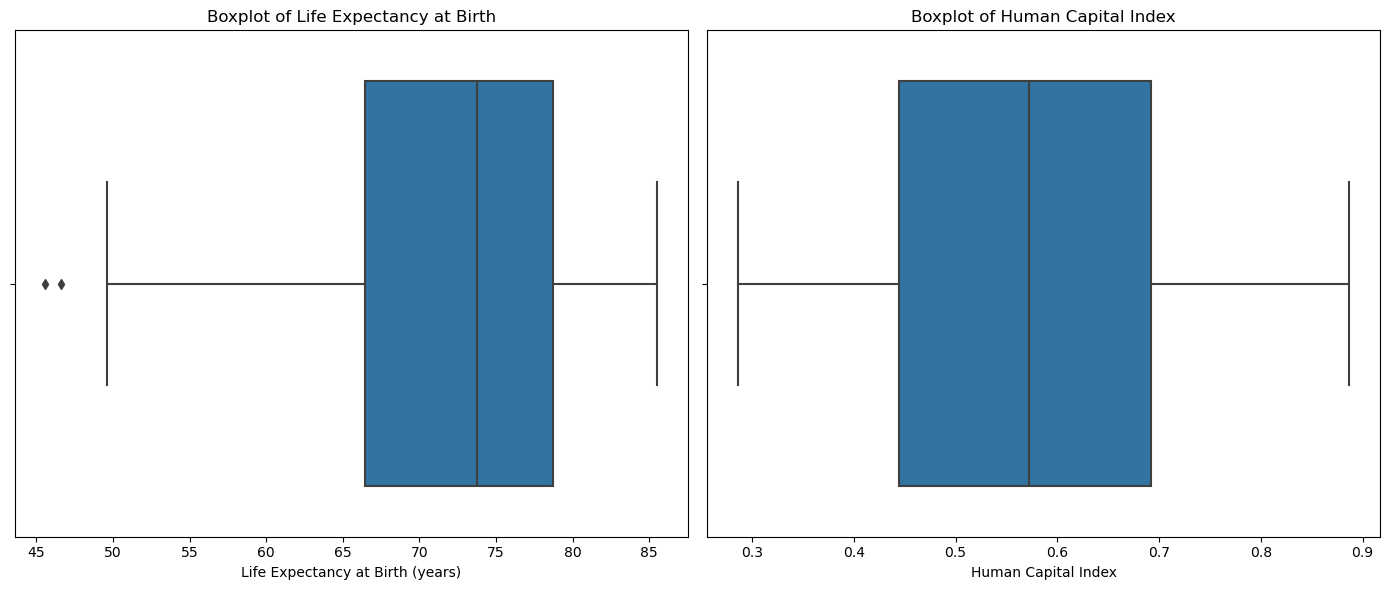

In [44]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figsize as needed

# Boxplot for Life Expectancy at Birth
sns.boxplot(x=dataset['life_expectancy_at_birth'], ax=axes[0])
axes[0].set_title('Boxplot of Life Expectancy at Birth')
axes[0].set_xlabel('Life Expectancy at Birth (years)')

# Boxplot for Human Capital Index
sns.boxplot(x=dataset['human_capital_index'], ax=axes[1])
axes[1].set_title('Boxplot of Human Capital Index')
axes[1].set_xlabel('Human Capital Index')

# Adjust layout
plt.tight_layout()
plt.show()

In [45]:
pg.normality(dataset["life_expectancy_at_birth"])

,W,pval,normal
life_expectancy_at_birth,0.955218,2.841337e-12,False


In [46]:
pg.normality(dataset["human_capital_index"])

# Tests confirm that the data is not normally distributed

,W,pval,normal
human_capital_index,0.966252,2.771554e-10,False


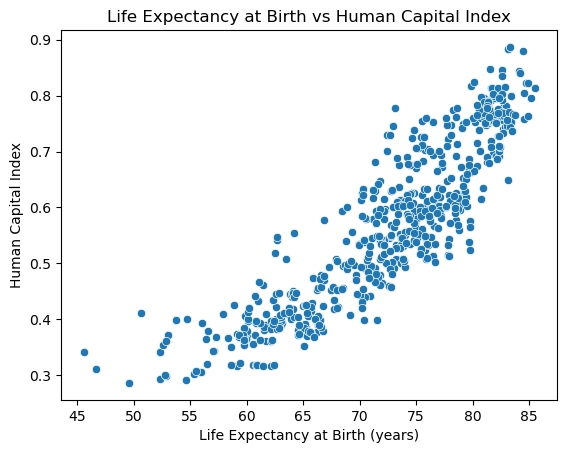

In [47]:
# Create visualization of correlation
sns.scatterplot(data=dataset, x='life_expectancy_at_birth', y='human_capital_index')
plt.title('Life Expectancy at Birth vs Human Capital Index')
plt.xlabel('Life Expectancy at Birth (years)')
plt.ylabel('Human Capital Index')
plt.show()

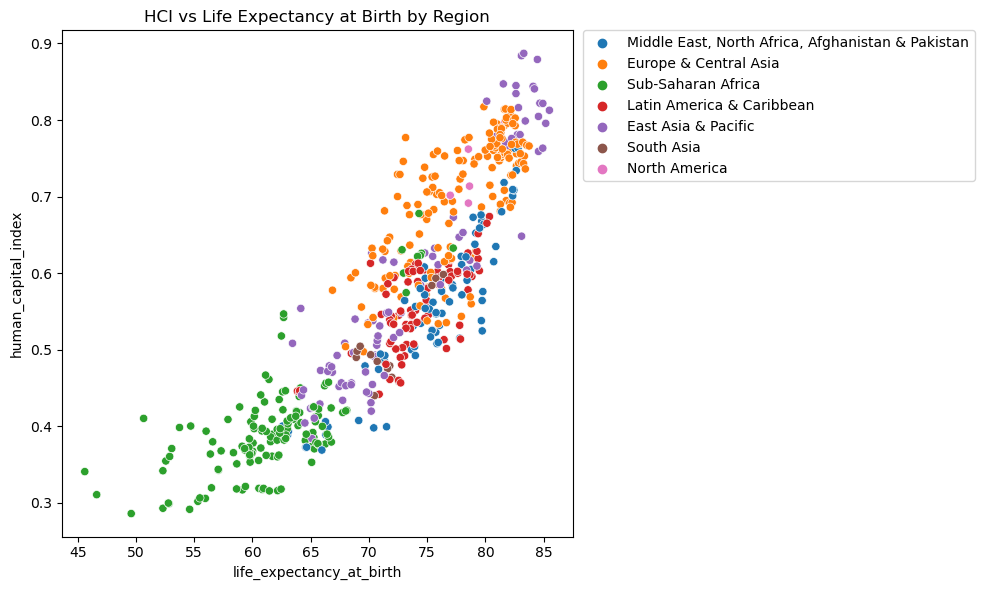

In [48]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=dataset,
    y="human_capital_index",
    x="life_expectancy_at_birth",
    hue="Region"
)

# Legend outside right
ax.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0
)

plt.title("HCI vs Life Expectancy at Birth by Region")
plt.tight_layout()
plt.show()


In [49]:
# Select rows for the two regions and only the desired columns
dataset2 = dataset.loc[
	dataset["Region"].isin(["East Asia & Pacific", "Europe & Central Asia"]),
	["human_capital_index", "Region", "life_expectancy_at_birth"]
].copy()

In [50]:
group1_hci = dataset2.loc[dataset2["Region"] == "East Asia & Pacific", "human_capital_index"]
group2_hci = dataset2.loc[dataset2["Region"] == "Europe & Central Asia", "human_capital_index"]

group1_life = dataset2.loc[dataset2["Region"] == "East Asia & Pacific", "life_expectancy_at_birth"]
group2_life = dataset2.loc[dataset2["Region"] == "Europe & Central Asia", "life_expectancy_at_birth"]





In [51]:
# Run MWU test to see if the distributions of the Regions significantly different
pg.mwu(group1_hci, group2_hci)

,U-val,alternative,p-val,RBC,CLES
MWU,5023.5,two-sided,0.000004,-0.34747,0.326265


In [52]:
pg.mwu(group1_life, group2_life)

,U-val,alternative,p-val,RBC,CLES
MWU,5636.0,two-sided,0.000386,-0.267909,0.366045


In [53]:
# Calculate Spearman correlation within each region
def spearman_by_group(group):
    return pg.corr(group["life_expectancy_at_birth"], group["human_capital_index"], method="spearman")

results = dataset2.groupby("Region").apply(spearman_by_group)
print(results)

                                  n         r         CI95%         p-val  \
Region                                                                      
East Asia & Pacific   spearman   89  0.893424  [0.84, 0.93]  5.522349e-32   
Europe & Central Asia spearman  173  0.717542  [0.64, 0.78]  1.169002e-28   

                                power  
Region                                 
East Asia & Pacific   spearman    1.0  
Europe & Central Asia spearman    1.0  


In both East Asia & Pacific and Europe & Central Asia, higher human capital index values are strongly associated with higher life expectancy at birth. This association is slightly stronger in East Asia & Pacific than in Europe & Central Asia. The correlations are highly statistically significant and robust.

In [54]:
# Use Spearman, because data is not normally distributed (tried everything)
# no outliers identified




### Research Question 3: Is there a relationship between GDP and CO₂ emissions? Does this relationship differ across income groups?

In [55]:
df_wbdi['year'] = pd.to_datetime(df_wbdi['date']).dt.year
df_recent = df_wbdi[df_wbdi['year'].between(2010, 2019)]
df_avg = df_recent.groupby(['country', 'Income group'], as_index=False).mean(numeric_only=True)

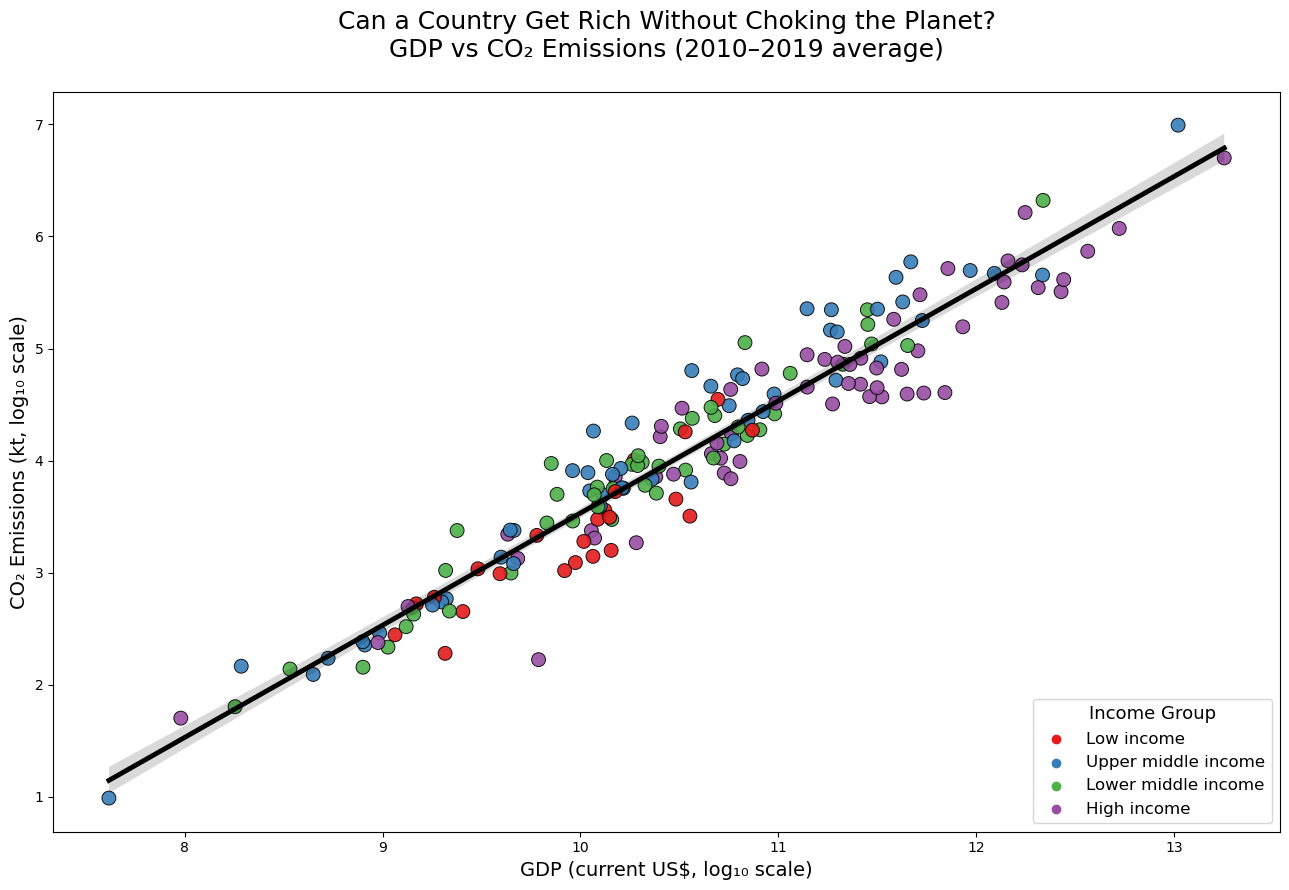

Overall correlation: r = 0.961, p = 9.38e-102


In [ ]:
df_corr = df_avg[['GDP_current_US', 'CO2_emisions', 'Income group']].dropna()
df_corr['log_GDP'] = np.log10(df_corr['GDP_current_US'] + 1)
df_corr['log_CO2'] = np.log10(df_corr['CO2_emisions'] + 1)

plt.figure(figsize=(13, 9))
sns.scatterplot(data=df_corr, x='log_GDP', y='log_CO2',
                hue='Income group', palette='Set1', s=100, alpha=0.9,
                edgecolor='black', linewidth=0.7)

sns.regplot(data=df_corr, x='log_GDP', y='log_CO2',
            scatter=False, color='black', line_kws={'lw': 3.5})

plt.title('Can a Country Get Rich Without Choking the Planet?\n'
          'GDP vs CO₂ Emissions (2010–2019 average)', fontsize=18, pad=25)
plt.xlabel('GDP (current US$, log₁₀ scale)', fontsize=14)
plt.ylabel('CO₂ Emissions (kt, log₁₀ scale)', fontsize=14)
plt.legend(title='Income Group', loc='lower right', fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.savefig('gdp_vs_co2_final.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation print
from scipy.stats import pearsonr
r, p = pearsonr(df_corr['log_GDP'], df_corr['log_CO2'])
print(f"Overall correlation: r = {r:.3f}, p = {p:.2e}")